<a href="https://colab.research.google.com/github/dkapesa/sales-analytics/blob/main/retail_customer_segmentation_clv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stage 1 – Data Import & Initial Inspection


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
df = pd.read_csv('/content/sales_transactions.csv')

In [ ]:
df.head()
df.info()
df.describe()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Order ID      1194 non-null   object
 1   Amount        1194 non-null   int64 
 2   Profit        1194 non-null   int64 
 3   Quantity      1194 non-null   int64 
 4   Category      1194 non-null   object
 5   Sub-Category  1194 non-null   object
 6   PaymentMode   1194 non-null   object
 7   Order Date    1194 non-null   object
 8   CustomerName  1194 non-null   object
 9   State         1194 non-null   object
 10  City          1194 non-null   object
 11  Year-Month    1194 non-null   object
dtypes: int64(3), object(9)
memory usage: 112.1+ KB


(1194, 12)

In [ ]:
df.isnull().sum()
df.duplicated().sum()

np.int64(0)

In [ ]:
df.dtypes

,0
Order ID,object
Amount,int64
Profit,int64
Quantity,int64
Category,object
Sub-Category,object
PaymentMode,object
Order Date,object
CustomerName,object
State,object


In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [ ]:
print('Unique customers:', df['CustomerName'].nunique())
print('Date range:', df['Order Date'].min(), 'to', df['Order Date'].max())
print('Total revenue:', df['Amount'].sum())
print('Total profit:', df['Profit'].sum())

Unique customers: 802
Date range: 2020-03-22 00:00:00 to 2025-03-15 00:00:00
Total revenue: 6182639
Total profit: 1610697


## Stage 2 – Data Cleaning & Feature Engineering
### Objective
Prepare clean, analysis-ready data and create RFM features for customer segmentation and lifetime value modelling.


In [ ]:
# Check duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Remove duplicates if necessary
df = df.drop_duplicates()

# Confirm numeric columns are correct
num_cols = ['Amount', 'Profit', 'Quantity']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# Check for negative or zero values
print("Negative or zero amounts:", (df['Amount'] <= 0).sum())

# Check date validity
print("Earliest date:", df['Order Date'].min())
print("Latest date:", df['Order Date'].max())

Duplicate rows: 0
Negative or zero amounts: 0
Earliest date: 2020-03-22 00:00:00
Latest date: 2025-03-15 00:00:00


In [ ]:
# Extract temporal features
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['DayOfWeek'] = df['Order Date'].dt.day_name()

# Aggregate to customer level
customer_df = df.groupby('CustomerName').agg({
    'Order Date': lambda x: (df['Order Date'].max() - x.max()).days,  # Recency
    'Order ID': 'nunique',  # Frequency
    'Amount': 'sum',        # Monetary
    'Profit': 'sum'         # Profit
}).reset_index()

# Rename columns
customer_df.columns = ['CustomerName', 'Recency', 'Frequency', 'Monetary', 'TotalProfit']

# Add Average Order Value (AOV)
customer_df['AOV'] = customer_df['Monetary'] / customer_df['Frequency']

# Optional: Profit Margin
customer_df['ProfitMargin'] = (customer_df['TotalProfit'] / customer_df['Monetary']).round(2)

customer_df.head()

,CustomerName,Recency,Frequency,Monetary,TotalProfit,AOV,ProfitMargin
0,Aaron Dunn,1150,1,7644,2428,7644.0,0.32
1,Aaron Johnson,443,1,19018,6161,19018.0,0.32
2,Aaron Jones,815,1,9431,691,9431.0,0.07
3,Aaron Kim,1776,1,15458,3450,15458.0,0.22
4,Abigail Brown,1156,1,3522,898,3522.0,0.25


Total customers after aggregation: 802

Descriptive stats:


,Recency,Frequency,Monetary,TotalProfit,AOV,ProfitMargin
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,896.988778,1.006234,7709.026185,2008.350374,7655.739401,0.259988
std,511.142991,0.078761,5229.211665,1693.766648,5162.231183,0.129565
min,0.000000,1.000000,523.000000,52.000000,523.000000,0.010000
25%,463.250000,1.000000,3882.750000,727.000000,3877.000000,0.160000
50%,905.000000,1.000000,6937.500000,1575.000000,6933.000000,0.250000
75%,1306.000000,1.000000,9908.000000,2826.000000,9902.500000,0.370000
max,1819.000000,2.000000,28557.000000,8840.000000,28557.000000,0.500000


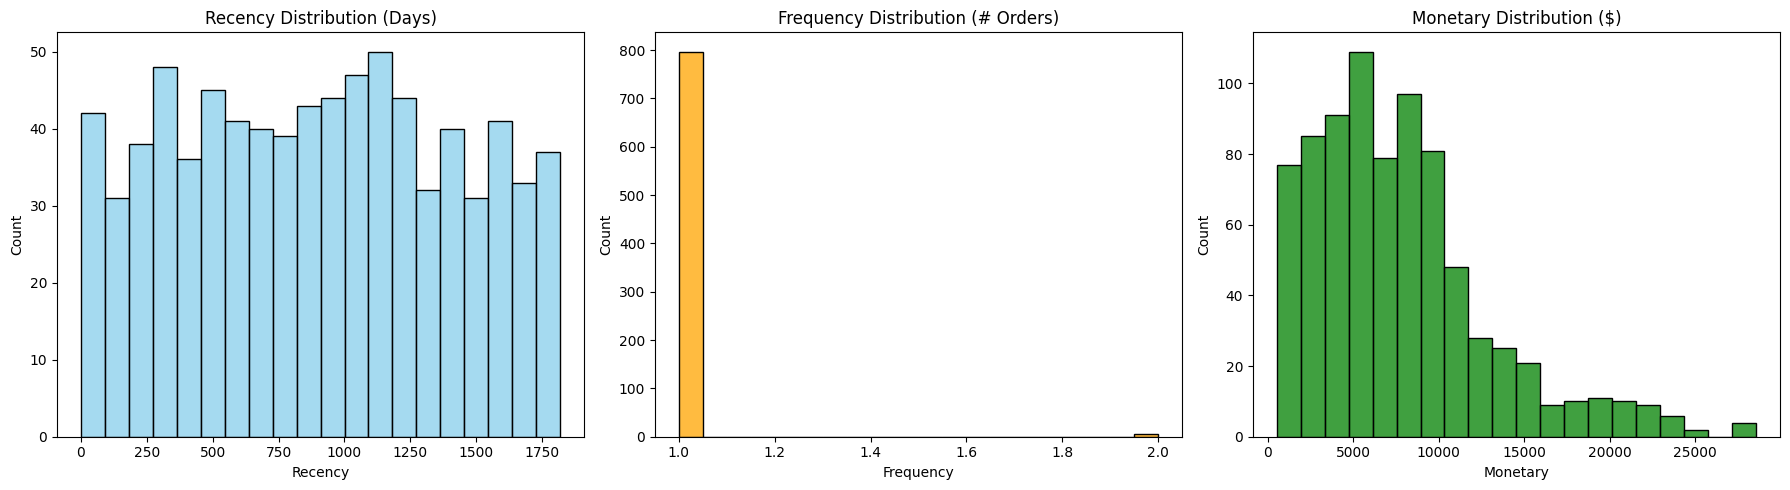

In [ ]:
print("Total customers after aggregation:", customer_df.shape[0])
print("\nDescriptive stats:")
display(customer_df.describe())

# Distribution visualizations
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(customer_df['Recency'], bins=20, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution (Days)')
sns.histplot(customer_df['Frequency'], bins=20, ax=axes[1], color='orange')
axes[1].set_title('Frequency Distribution (# Orders)')
sns.histplot(customer_df['Monetary'], bins=20, ax=axes[2], color='green')
axes[2].set_title('Monetary Distribution ($)')
plt.tight_layout()
plt.show()

## Stage 3 – Exploratory Data Analysis (EDA)
### Objective
Explore customer behaviour and spending patterns to inform segmentation and CLV modelling.


Total customers: 802
Total revenue: $6,182,639.00
Average revenue per customer: $7,709.03


,CustomerName,Monetary,Frequency,Recency
163,Cory Evans,28557,1,272
234,Emily Ellison,27352,1,941
256,George Foster,27352,1,1009
584,Nicholas Anderson,27352,1,1215
400,Katherine Williams,25121,1,1020
278,Jacqueline Harris,24433,2,771
617,Randy Johnson,24295,1,811
739,Tammy Bell,23895,1,725
96,Brian Green,23737,1,1189
800,Zachary Perez,23737,1,1136


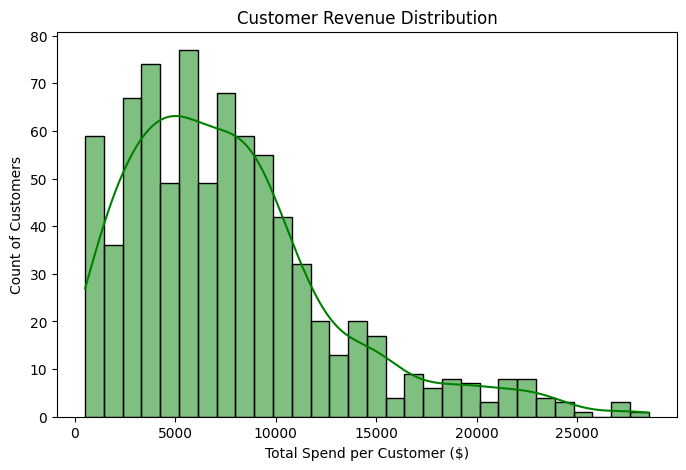

In [ ]:
# 1.Customer Overview
# Total customers and revenue
print(f"Total customers: {customer_df['CustomerName'].nunique()}")
print(f"Total revenue: ${customer_df['Monetary'].sum():,.2f}")
print(f"Average revenue per customer: ${customer_df['Monetary'].mean():,.2f}")

# Top 10 customers by revenue
top_customers = customer_df.nlargest(10, 'Monetary')[['CustomerName', 'Monetary', 'Frequency', 'Recency']]
display(top_customers)

# Visualise distribution of total customer revenue
plt.figure(figsize=(8,5))
sns.histplot(customer_df['Monetary'], bins=30, kde=True, color='green')
plt.title("Customer Revenue Distribution")
plt.xlabel("Total Spend per Customer ($)")
plt.ylabel("Count of Customers")
plt.show()

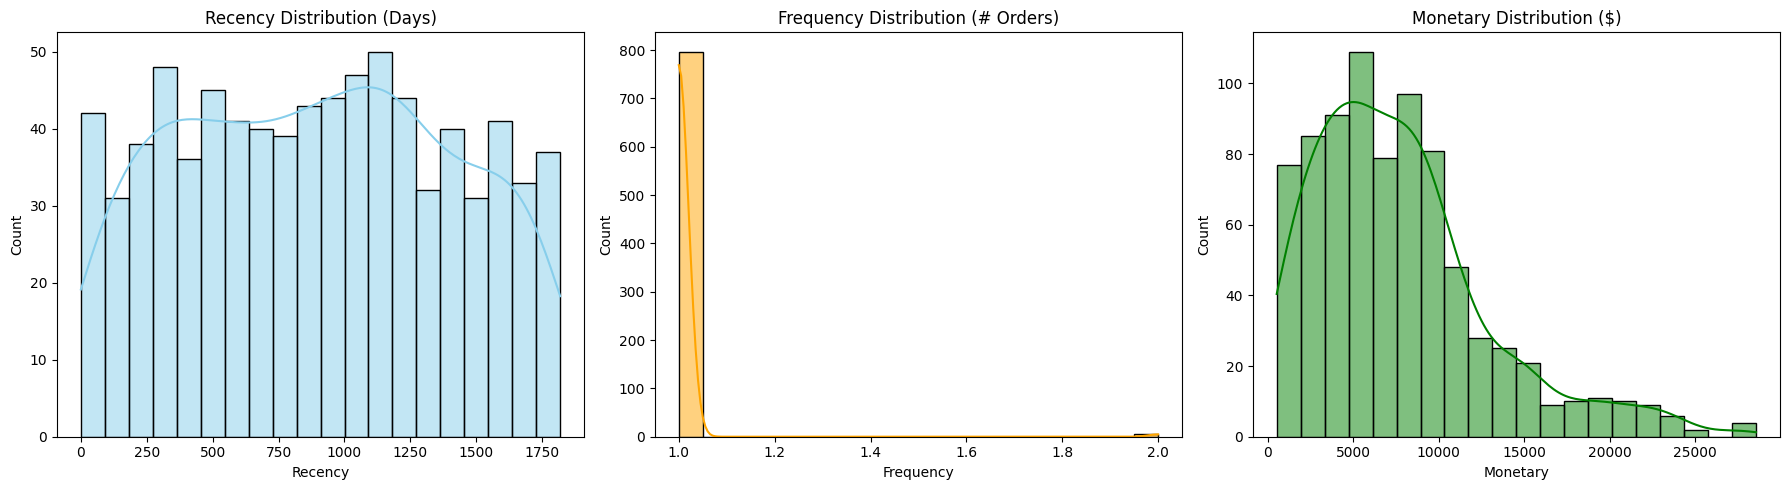

In [ ]:
# RFM Metric Distributions
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(customer_df['Recency'], bins=20, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution (Days)')
sns.histplot(customer_df['Frequency'], bins=20, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Frequency Distribution (# Orders)')
sns.histplot(customer_df['Monetary'], bins=20, kde=True, ax=axes[2], color='green')
axes[2].set_title('Monetary Distribution ($)')
plt.tight_layout()
plt.show()

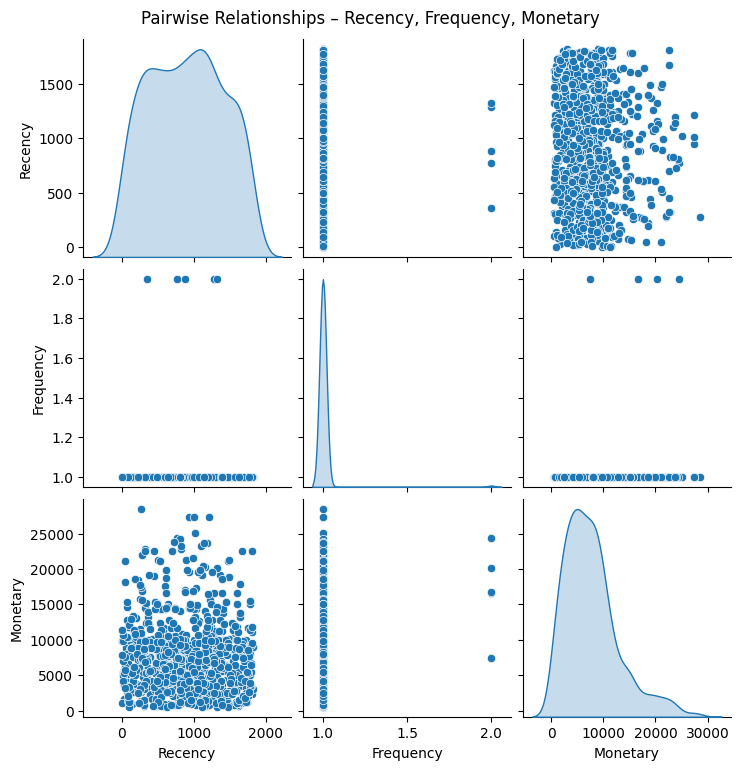

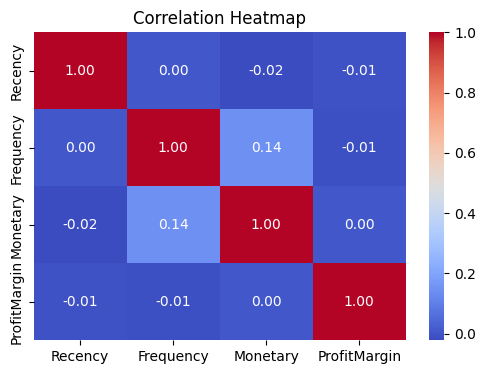

In [ ]:
# Relationships Between Metrics
sns.pairplot(customer_df[['Recency','Frequency','Monetary']], diag_kind='kde')
plt.suptitle("Pairwise Relationships – Recency, Frequency, Monetary", y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(customer_df[['Recency','Frequency','Monetary','ProfitMargin']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

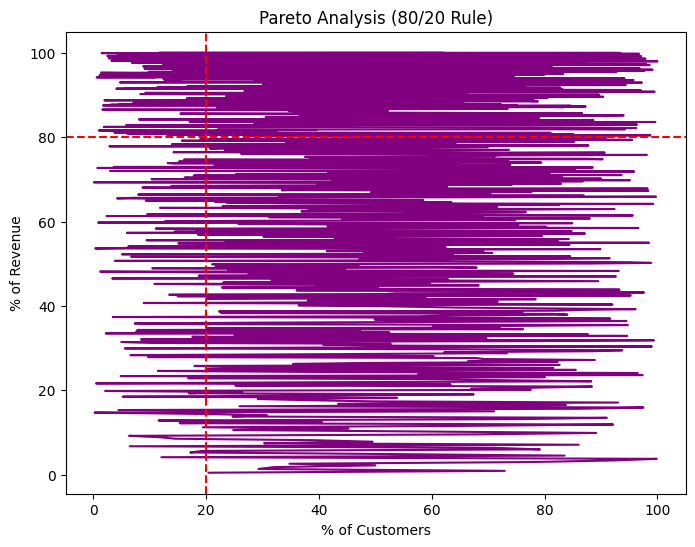

In [ ]:
# Revenue Concentration (Pareto 80/20 Analysis)
customer_df_sorted = customer_df.sort_values('Monetary', ascending=False)
customer_df_sorted['CumulativeRevenue'] = customer_df_sorted['Monetary'].cumsum()
customer_df_sorted['CumulativePerc'] = 100 * customer_df_sorted['CumulativeRevenue'] / customer_df_sorted['Monetary'].sum()
customer_df_sorted['CustomerPerc'] = 100 * (customer_df_sorted.index + 1) / len(customer_df_sorted)

plt.figure(figsize=(8,6))
plt.plot(customer_df_sorted['CustomerPerc'], customer_df_sorted['CumulativePerc'], color='purple')
plt.axhline(y=80, color='r', linestyle='--')
plt.axvline(x=20, color='r', linestyle='--')
plt.title("Pareto Analysis (80/20 Rule)")
plt.xlabel("% of Customers")
plt.ylabel("% of Revenue")
plt.show()

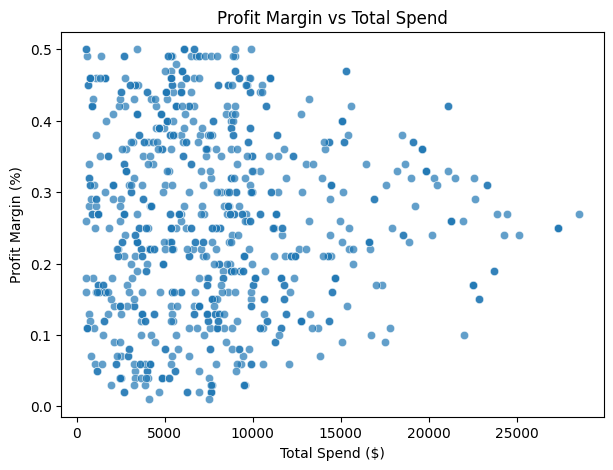

In [ ]:
# Probability Insights
plt.figure(figsize=(7,5))
sns.scatterplot(data=customer_df, x='Monetary', y='ProfitMargin', alpha=0.7)
plt.title("Profit Margin vs Total Spend")
plt.xlabel("Total Spend ($)")
plt.ylabel("Profit Margin (%)")
plt.show()

## Stage 4 – Customer Segmentation
### Objective
Segment customers based on their Recency, Frequency, and Monetary values using both quantile-based RFM scoring and K-Means clustering to identify key customer groups and growth opportunities.

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

rfm_scaled = customer_df[['Recency', 'Frequency', 'Monetary']].copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_scaled)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

In [ ]:
# RFM Quantile Segmentation
# Rank-first approach (recommended)
customer_df['R_rank'] = customer_df['Recency'].rank(method='first', ascending=True)   # recent -> lower recency -> smaller rank
customer_df['F_rank'] = customer_df['Frequency'].rank(method='first', ascending=True)
customer_df['M_rank'] = customer_df['Monetary'].rank(method='first', ascending=True)

customer_df['R_Quartile'] = pd.qcut(customer_df['R_rank'], 4, labels=[4,3,2,1]).astype(int)  # higher score = better (more recent)
customer_df['F_Quartile'] = pd.qcut(customer_df['F_rank'], 4, labels=[1,2,3,4]).astype(int)  # higher score = better (more frequent)
customer_df['M_Quartile'] = pd.qcut(customer_df['M_rank'], 4, labels=[1,2,3,4]).astype(int)  # higher score = better (more monetary)

# Combine
customer_df['RFM_Score'] = customer_df['R_Quartile'] + customer_df['F_Quartile'] + customer_df['M_Quartile']

# Segment function (example)
def segment(x):
    if x >= 10:
        return 'Champions'
    elif x >= 8:
        return 'Loyal Customers'
    elif x >= 6:
        return 'Potential Loyalists'
    elif x >= 4:
        return 'At Risk'
    else:
        return 'Lost'

customer_df['Segment'] = customer_df['RFM_Score'].apply(segment)

# Quick check
customer_df[['CustomerName','Recency','Frequency','Monetary','R_Quartile','F_Quartile','M_Quartile','RFM_Score','Segment']].head()

,CustomerName,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFM_Score,Segment
0,Aaron Dunn,1150,1,7644,2,1,3,6,Potential Loyalists
1,Aaron Johnson,443,1,19018,4,1,4,9,Loyal Customers
2,Aaron Jones,815,1,9431,3,1,3,7,Potential Loyalists
3,Aaron Kim,1776,1,15458,1,1,4,6,Potential Loyalists
4,Abigail Brown,1156,1,3522,2,1,1,4,At Risk


/tmp/ipython-input-4289145727.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customer_df, x='Segment', order=customer_df['Segment'].value_counts().index, palette='viridis')


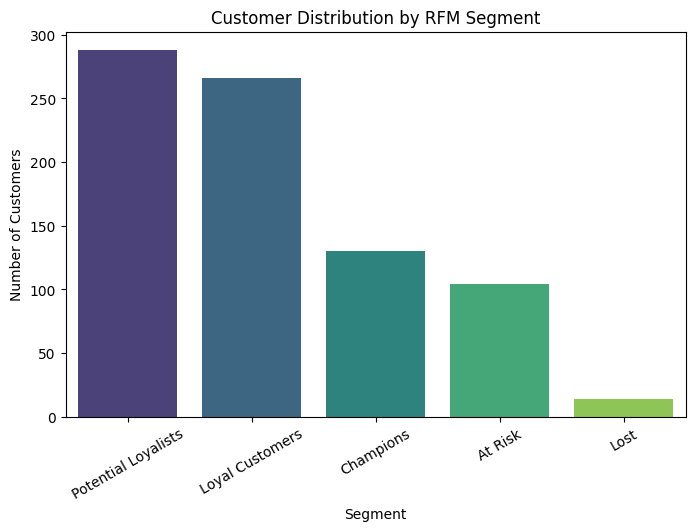

In [ ]:
# Visualise RFM Segments
plt.figure(figsize=(8,5))
sns.countplot(data=customer_df, x='Segment', order=customer_df['Segment'].value_counts().index, palette='viridis')
plt.title("Customer Distribution by RFM Segment")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.show()

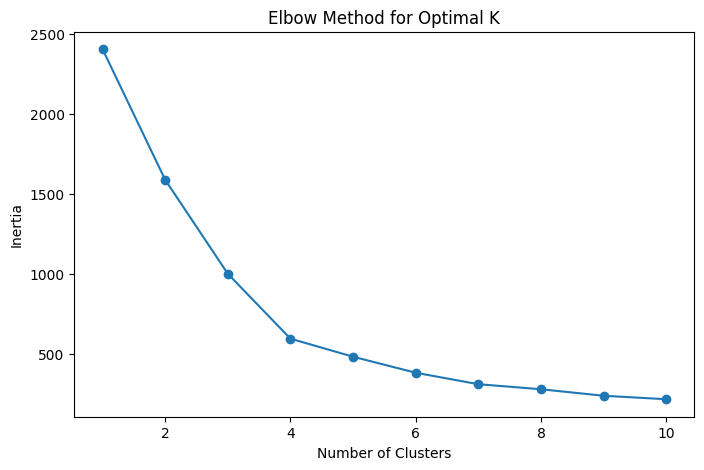

In [ ]:
# K-Means Clustering - Elbow Method
from sklearn.cluster import KMeans
inertia = []

for k in range(1,11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Fit K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [ ]:
# Cluster Profiling
cluster_profile = customer_df.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(2)
cluster_profile['CustomerCount'] = customer_df['Cluster'].value_counts()
display(cluster_profile)

,Recency,Frequency,Monetary,CustomerCount
Cluster,,,,
0,1347.75,1.0,5900.59,345
1,924.00,2.0,17094.40,5
2,449.04,1.0,6215.62,342
3,874.75,1.0,17597.47,110


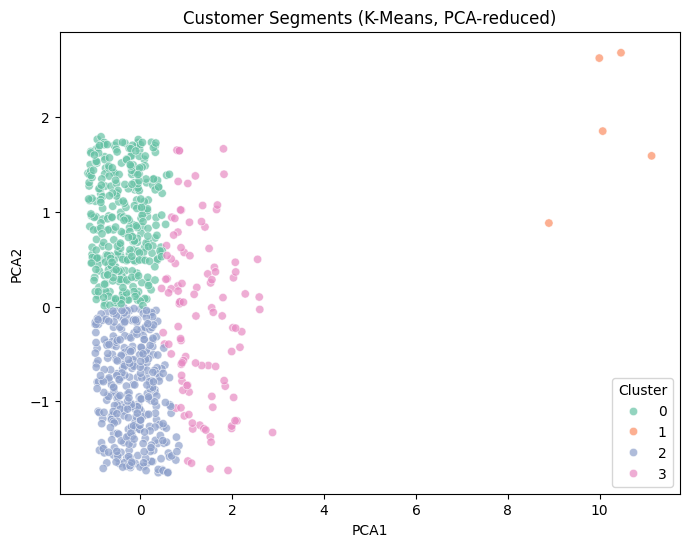

In [ ]:
# Cluser Visualisation using PCA
from sklearn.decomposition import PCA

pca = PCA(2)
pca_components = pca.fit_transform(rfm_scaled)
customer_df['PCA1'], customer_df['PCA2'] = pca_components[:,0], pca_components[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_df, palette='Set2', alpha=0.7)
plt.title("Customer Segments (K-Means, PCA-reduced)")
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Comparing RFM vs K-Means Segments
comparison = pd.crosstab(customer_df['Segment'], customer_df['Cluster'])
display(comparison)

Cluster,0,1,2,3
Segment,,,,
At Risk,95,0,9,0
Champions,5,4,80,41
Lost,14,0,0,0
Loyal Customers,74,1,143,48
Potential Loyalists,157,0,110,21


## Stage 5 — Customer Lifetime Value (CLV) & Retention Forecasting

In [ ]:
!pip install lifetimes --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

In [ ]:
# Building lifetimes summary table (frequency, recency, T, monetary)
# Determine observation end date
observation_end = df['Order Date'].max()
print("Observation period end:", observation_end.date())

# Build summary table using lifetimes helper (recency and T in days by setting freq='D')
summary = summary_data_from_transaction_data(
    transactions=df,
    customer_id_col='CustomerName',         # adjust if you use a different customer id column
    datetime_col='Order Date',
    monetary_value_col='Amount',           # total transaction value column
    observation_period_end=observation_end,
    freq='D'                               # 'D' for days
)

# summary will have:
# frequency: number of repeat purchases (i.e., total transactions - 1)
# recency: age of customer at last purchase (in days)
# T: age of customer in dataset (in days)
# monetary_value: average value per transaction for that customer (only for customers with frequency>0)

summary = summary.reset_index().rename(columns={'index':'CustomerName'})
summary.head()

Observation period end: 2025-03-15


,CustomerName,frequency,recency,T,monetary_value
0,Aaron Dunn,0.0,0.0,1150.0,0.0
1,Aaron Johnson,0.0,0.0,443.0,0.0
2,Aaron Jones,0.0,0.0,815.0,0.0
3,Aaron Kim,0.0,0.0,1776.0,0.0
4,Abigail Brown,0.0,0.0,1156.0,0.0


In [ ]:
# Fit BG/NBD (purchase frequency & probability alive)
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(bgf.summary)

               coef   se(coef)  lower 95% bound  upper 95% bound
r      3.171032e-03   0.001745        -0.000250         0.006592
alpha  1.187262e+02  91.738296       -61.080889       298.533232
a      1.015776e-04        NaN              NaN              NaN
b      1.357630e-10        NaN              NaN              NaN


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


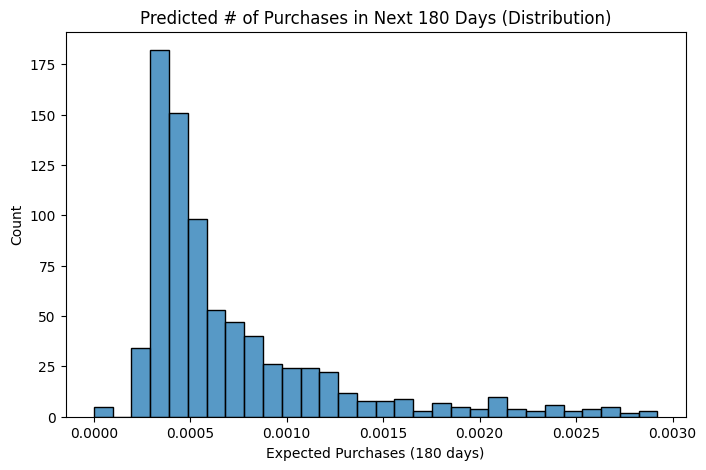

In [ ]:
# Plot expected number of purchases for horizon (e.g., next 180 days)
t = 180  # horizon in days (6 months)
summary['pred_purchases_180d'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])

plt.figure(figsize=(8,5))
sns.histplot(summary['pred_purchases_180d'], bins=30, kde=False)
plt.title("Predicted # of Purchases in Next 180 Days (Distribution)")
plt.xlabel("Expected Purchases (180 days)")
plt.show()

In [ ]:
# Probability
summary['prob_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])
summary[['CustomerName','frequency','recency','T','prob_alive']].head()

,CustomerName,frequency,recency,T,prob_alive
0,Aaron Dunn,0.0,0.0,1150.0,1.0
1,Aaron Johnson,0.0,0.0,443.0,1.0
2,Aaron Jones,0.0,0.0,815.0,1.0
3,Aaron Kim,0.0,0.0,1776.0,1.0
4,Abigail Brown,0.0,0.0,1156.0,1.0


In [ ]:
# Fit Gamma-Gamma (monetary model) and predict expected average spend
# Filter customers with frequency>0 and positive monetary_value (required to fit GammaGamma)
gg_df = summary[(summary['frequency'] > 0) & (summary['monetary_value'] > 0)].copy()
print("Customers used for Gamma-Gamma:", gg_df.shape[0])

ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(gg_df['frequency'], gg_df['monetary_value'])
print(ggf.summary)

Customers used for Gamma-Gamma: 5
        coef  se(coef)  lower 95% bound  upper 95% bound
p  11.011984  7.387576        -3.467665        25.491633
q   0.250077  0.123492         0.008032         0.492122
v  10.805940  7.447579        -3.791316        25.403196


In [ ]:
# Calculate CLV for horizon (e.g., 180 days or 365 days)

# Set horizon (in days) for CLV forecast
horizon_days = 180  # e.g., 180 days ≈ 6 months

# Compute expected number of purchases in the horizon using BG/NBD
summary['exp_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    horizon_days, summary['frequency'], summary['recency'], summary['T']
)

# Use observed order value as average purchase value
# For customers with monetary_value = 0, fallback to global mean
global_mean = df['Amount'].mean()
summary['avg_order_value'] = summary['monetary_value'].replace(0, global_mean)

# Calculate predicted CLV
summary['predicted_clv'] = summary['exp_purchases'] * summary['avg_order_value']

# Quick check of top customers by CLV
summary[['CustomerName','frequency','avg_order_value','exp_purchases','predicted_clv']].sort_values(
    'predicted_clv', ascending=False
).head(10)

,CustomerName,frequency,avg_order_value,exp_purchases,predicted_clv
222,Dr. Terry Alvarado,0.0,5178.089615,0.002922,15.128625
230,Elizabeth Hernandez,0.0,5178.089615,0.002906,15.046019
770,Vanessa Bauer,0.0,5178.089615,0.002844,14.725010
788,William Martin,0.0,5178.089615,0.002814,14.569918
657,Roger Harris,0.0,5178.089615,0.002799,14.493669
620,Raymond Reyes,0.0,5178.089615,0.002714,14.053404
666,Ryan Hale,0.0,5178.089615,0.002687,13.912882
426,Kimberly Beard,0.0,5178.089615,0.002674,13.843731
323,Jennifer Arnold,0.0,5178.089615,0.002647,13.707588
544,Michelle Anderson,0.0,5178.089615,0.002647,13.707588


In [ ]:
# Merge CLV with segments
# Merge with segment info
df_clv = customer_df.merge(
    summary.set_index('CustomerName')[['predicted_clv','exp_purchases']],
    left_on='CustomerName',
    right_index=True,
    how='left'
)

# Quick segment-level aggregation
clv_by_segment = df_clv.groupby('Segment').agg(
    customers=('CustomerName','nunique'),
    avg_clv=('predicted_clv','mean'),
    total_clv=('predicted_clv','sum'),
    avg_expected_purchases=('exp_purchases','mean')
).reset_index().sort_values('total_clv', ascending=False)

clv_by_segment

,Segment,customers,avg_clv,total_clv,avg_expected_purchases
3,Loyal Customers,266,4.130756,1098.781103,0.000798
4,Potential Loyalists,288,3.114543,896.988458,0.000601
1,Champions,130,5.796871,753.593166,0.001119
0,At Risk,104,2.049710,213.169840,0.000396
2,Lost,14,1.692627,23.696775,0.000327


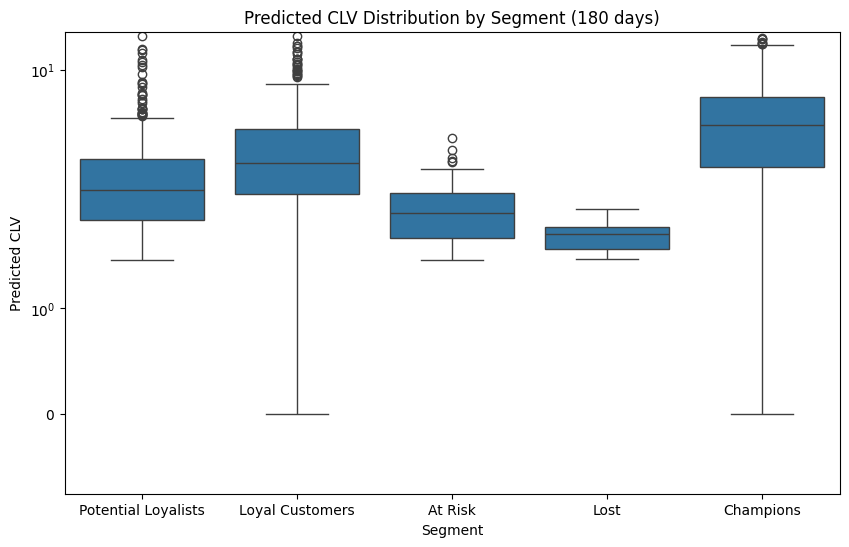

In [ ]:
# Visualising CLV distribution by segment
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(data=df_clv, x='Segment', y='predicted_clv')
plt.yscale('symlog')  # handles heavy-tailed distribution nicely
plt.title(f'Predicted CLV Distribution by Segment ({horizon_days} days)')
plt.ylabel('Predicted CLV')
plt.xlabel('Segment')
plt.show()

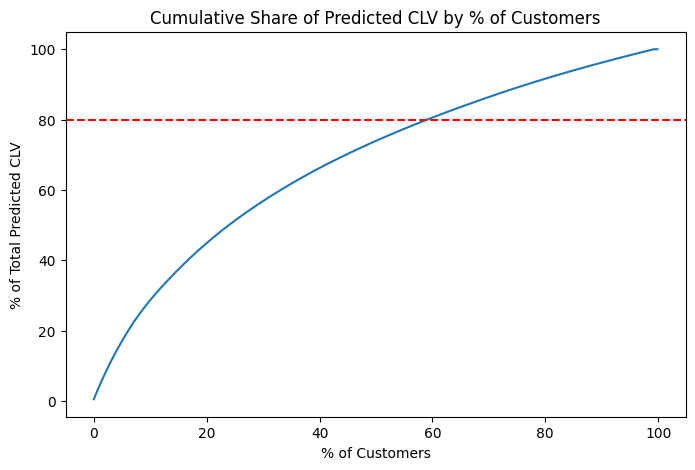

In [ ]:
# Cumulative CLV / Pareto analysis
# Sort customers by predicted CLV
df_clv_sorted = df_clv.sort_values('predicted_clv', ascending=False)
df_clv_sorted['cum_clv'] = df_clv_sorted['predicted_clv'].cumsum()
df_clv_sorted['cum_clv_pct'] = df_clv_sorted['cum_clv'] / df_clv_sorted['predicted_clv'].sum()

# Plot cumulative CLV share
plt.figure(figsize=(8,5))
plt.plot(np.arange(len(df_clv_sorted))/len(df_clv_sorted)*100, df_clv_sorted['cum_clv_pct']*100)
plt.axhline(80, color='red', linestyle='--')
plt.title('Cumulative Share of Predicted CLV by % of Customers')
plt.xlabel('% of Customers')
plt.ylabel('% of Total Predicted CLV')
plt.show()